# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline


from fastai.tabular.all import*
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Reading the Datasets

In [2]:
# train = pd.read_csv("train.csv", low_memory=False).rename(columns=str.lower)
# test = pd.read_csv("test.csv", low_memory=False).rename(columns=str.lower)
# original = pd.read_csv("cubic_zirconia.csv", low_memory=False).rename(columns=str.lower)
# ss= pd.read_csv("sample_submission.csv", low_memory=False).rename(columns=str.lower)

train = pd.read_csv("/kaggle/input/playground-series-s3e8/train.csv", low_memory=False).rename(columns=str.lower)
test = pd.read_csv("/kaggle/input/playground-series-s3e8/test.csv", low_memory=False).rename(columns=str.lower)
original = pd.read_csv("/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv", low_memory=False).rename(columns=str.lower)
ss= pd.read_csv("/kaggle/input/playground-series-s3e8/sample_submission.csv", low_memory=False).rename(columns=str.lower)


# Data Analysis and Preprocessing

In [3]:
# Copying the datasets to perform data analysis, preprocessing, etc.
df_train = train.copy()
df_test = test.copy()

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [5]:
df_train.head()

,id,carat,cut,color,clarity,...,table,x,y,z,price
0,0,1.52,Premium,F,VS2,...,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,...,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,...,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,...,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,...,59.0,7.65,7.61,4.77,14453


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129050 entries, 0 to 129049
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       129050 non-null  int64  
 1   carat    129050 non-null  float64
 2   cut      129050 non-null  object 
 3   color    129050 non-null  object 
 4   clarity  129050 non-null  object 
 5   depth    129050 non-null  float64
 6   table    129050 non-null  float64
 7   x        129050 non-null  float64
 8   y        129050 non-null  float64
 9   z        129050 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 9.8+ MB


In [7]:
df_train.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


In [8]:
df_test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,193573,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,193574,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,193575,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,193576,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,193577,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24


In [9]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


In [10]:
original.head()

,unnamed: 0,carat,cut,color,clarity,...,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,...,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,...,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,...,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,...,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,...,59.0,4.35,4.43,2.65,779


In [11]:
original.describe()

,unnamed: 0,carat,depth,table,x,y,z,price
count,26967.000000,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,13484.000000,0.798375,61.745147,57.456080,5.729854,5.733569,3.538057,3939.518115
std,7784.846691,0.477745,1.412860,2.232068,1.128516,1.166058,0.720624,4024.864666
min,1.000000,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,6742.500000,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,13484.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,20225.500000,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,26967.000000,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,18818.000000


# Handling Missing & Duplicate Values

In [12]:
# Only the original dataset has missing values

# Missing values in original dataset
original.isna().sum()

unnamed: 0      0
carat           0
cut             0
color           0
clarity         0
depth         697
table           0
x               0
y               0
z               0
price           0
dtype: int64

In [13]:
# Dropping missing values. as the amount of missing values is very less
original.dropna(axis=0, inplace=True)
# Removing the unnecessary column
original.drop("unnamed: 0", axis=1, inplace=True)

In [14]:
original.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [15]:
# Removing duplcate values
def remove_duplicates(df, drop=True):
    if drop: 
        df = df.drop_duplicates(subset=cols)
        return df
    else: 
        return df

# Combining Original & Train Datasets

In [16]:
# Addiing original dataset to the train dataset
df_train = pd.concat([df_train, original], axis=0, ignore_index=True)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219843 entries, 0 to 219842
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  float64
 1   carat    219843 non-null  float64
 2   cut      219843 non-null  object 
 3   color    219843 non-null  object 
 4   clarity  219843 non-null  object 
 5   depth    219843 non-null  float64
 6   table    219843 non-null  float64
 7   x        219843 non-null  float64
 8   y        219843 non-null  float64
 9   z        219843 non-null  float64
 10  price    219843 non-null  int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 18.5+ MB


Text(0.5, 0, 'price')

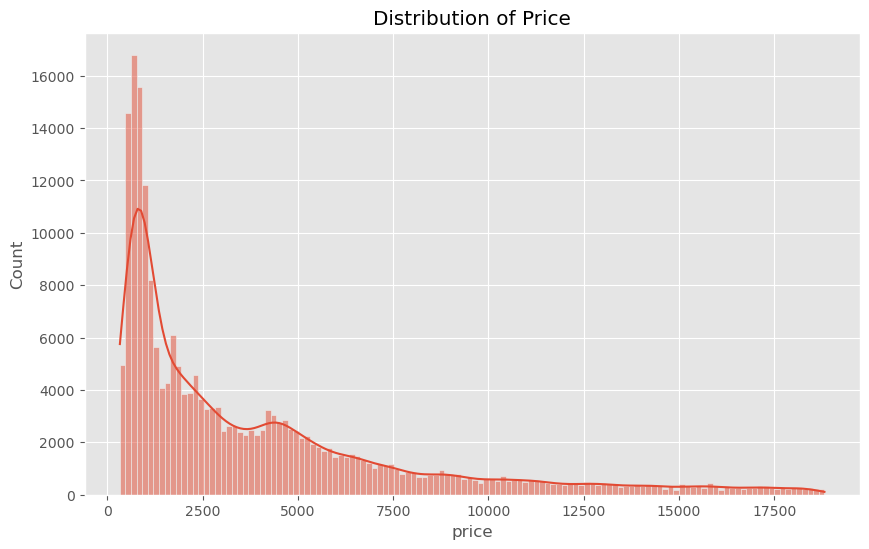

In [18]:
## Let's check the distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_train["price"], kde=True)
plt.title("Distribution of Price")
plt.xlabel("price")

`Target variable is not normally distrbuted for linear models it might affect the performance`

Text(0.5, 1.0, 'Spearman Rank Correlation')

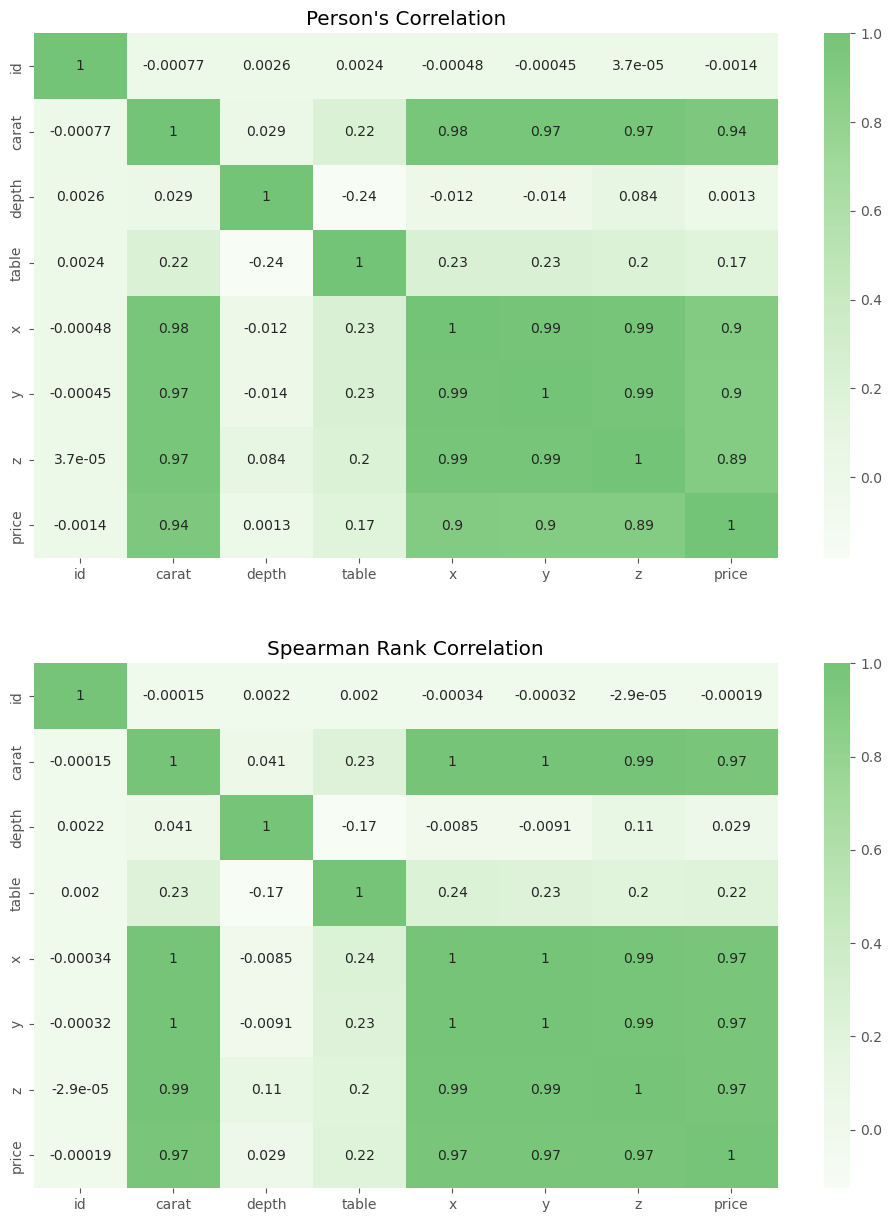

In [19]:
# Checking correlation between features and target variable
fig, ax = plt.subplots(2, 1, figsize=(12, 15))
sns.heatmap(df_train.corr(), annot=True, robust=True, center=True, cmap='Greens', ax=ax[0])
ax[0].set_title("Person's Correlation")

sns.heatmap(df_train.corr(method="spearman"), annot=True, robust=True, center=True, cmap='Greens', ax=ax[1])
ax[1].set_title("Spearman Rank Correlation")

## `Featrues "x", "y", "z" and "carat" have high linear correlation with target variable "price"`

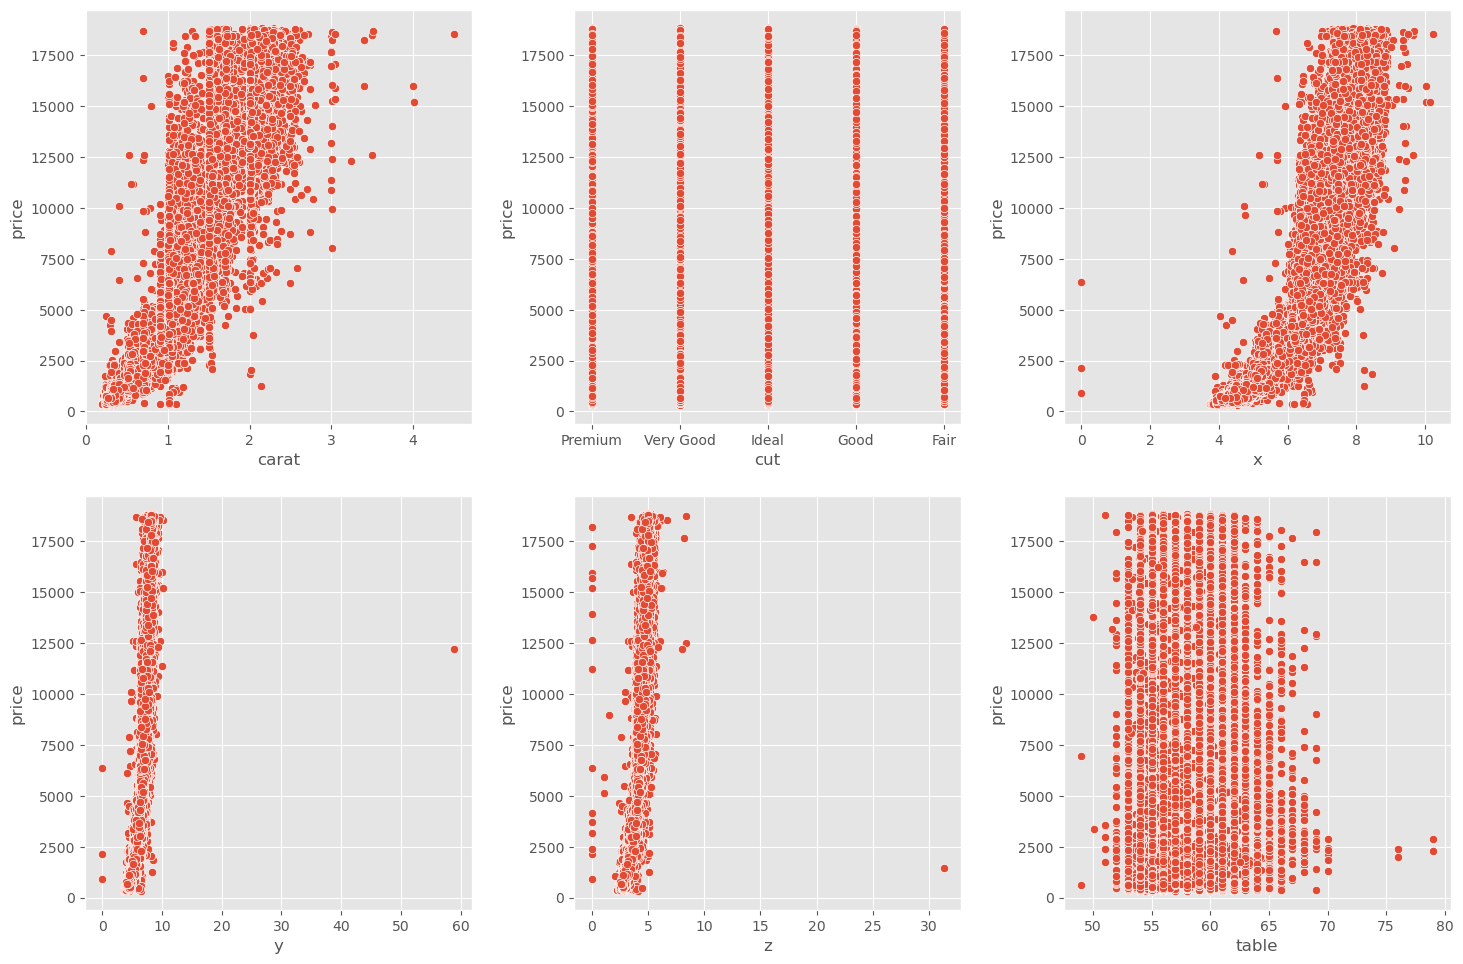

In [20]:
# Scatterplots of features having high correlation with "price"
cols =  ['carat', 'cut', 'x', 'y', 'z', "table"] 

plt.figure(figsize=(15, 10))
# iterate through indices and keys
for index, col in enumerate(cols):
    # new subplot with (i + 1)-th index laying on a grid
    plt.subplot(2, 3, index + 1)
    # drawing the plot
    sns.scatterplot(x=df_train[col], y=df_train['price'])
# render everything
plt.tight_layout(pad=2)
plt.show()

In [21]:
# cols =  ['carat', 'depth', 'table', 'x', 'y', 'z', "cut", "price"]
# sns.pairplot(df_train[cols])

# Feature Engineering

In [22]:
def feature_engineer(df):
    df['square_xyz'] = (df['x']**2) + (df['y']**2) + (df['z']**2)
    return df

# Handling Categorical Data

In [23]:
# Extracting categorcial and numerical columns
cat_columns = df_train.select_dtypes(include="object").columns.to_list()
num_columns = df_train.select_dtypes(include="number").columns.to_list()

print(f"Categorical columns: {cat_columns} \nNumerical columns: {num_columns}")

Categorical columns: ['cut', 'color', 'clarity'] 
Numerical columns: ['id', 'carat', 'depth', 'table', 'x', 'y', 'z', 'price']


In [24]:
def print_categorical(df, cat_columns):
    for col in cat_columns:
        print(f"{col}: {df[col].unique()}")

# Uniques categorical values of each categorical features
print_categorical(df_train, cat_columns)

cut: ['Premium' 'Very Good' 'Ideal' 'Good' 'Fair']
color: ['F' 'J' 'G' 'E' 'D' 'H' 'I']
clarity: ['VS2' 'SI2' 'VS1' 'SI1' 'IF' 'VVS2' 'VVS1' 'I1']


In [25]:
# All the categorical columns have categorical values with some order
# Encoding categorical columns
def map_cat_columns(df, cat_columns):
    # Unique categories of each cat column i.e "cut", "colors" & "clarity"
    cuts = {'Fair': 0,
            'Ideal': 1,
            'Good': 2,
            'Very Good': 3, 
            'Premium': 4}
    
    colors = {'J': 0,
              'I': 1,
              'H': 2,
              'G': 3,
              'F': 4,
              'E': 5,
              'D': 6} 
    
    clarities = {'I3': 0, 'I2': 1,'I1': 2,
                 'SI2': 3,'SI1': 4,
                 'VS2': 5,  'VS1': 6,
                 'VVS2': 7, 'VVS1': 8,
                 'IF': 9, 'FL': 10}
    
    for col, categories in zip(cat_columns, [cuts, colors, clarities]):
        df[col] = df[col].map(categories)
    
    return df

# Converting columns with object dtype to categorical dtype & encoding according to order
def encode_cat_columns(df):
    
    cuts = ['Premium', 'Very Good', 'Ideal', 'Good', 'Fair']
    colors = ['F', 'J', 'G', 'E', 'D', 'H', 'I']
    clarities = ['VS2', 'SI2', 'VS1', 'SI1', 'IF', 'VVS2', 'VVS1', 'I1']
    
    df["cut"] = df["cut"].astype("category")
    df["cut"].cat.set_categories(cuts, ordered=True, inplace=True)

    df["color"] = df["color"].astype("category")
    df["color"].cat.set_categories(colors, ordered=True, inplace=True)

    df["clarity"] = df["clarity"].astype("category")
    df["clarity"].cat.set_categories(clarities, ordered=True, inplace=True)
    
    return df

# Neural Networks 

In [26]:
# Encoding categorical columns
df_train_nn = df_train.copy()
df_test_nn = df_test.copy()

# Encoding categorical values
df_train_nn = encode_cat_columns(df_train_nn)
df_test_nn = encode_cat_columns(df_test_nn)

# Feature Engineering
df_train_nn = feature_engineer(df_train_nn)
df_test_nn = feature_engineer(df_test_nn)

# Drop duplicates
# df_train_nn = remove_duplicates(df_train_nn)

In [27]:
# Removing 'id' column
df_train_nn.drop("id", axis=1, inplace=True)
df_train_nn.head()

,carat,cut,color,clarity,depth,...,x,y,z,price,square_xyz
0,1.52,Premium,F,VS2,62.2,...,7.27,7.33,4.55,13619,127.2843
1,2.03,Very Good,J,SI2,62.0,...,8.06,8.12,5.05,13387,156.4005
2,0.70,Ideal,G,VS1,61.2,...,5.69,5.73,3.50,2772,77.4590
3,0.32,Ideal,G,VS1,61.6,...,4.38,4.41,2.71,666,45.9766
4,1.70,Premium,G,VS2,62.6,...,7.65,7.61,4.77,14453,139.1875


In [28]:
# Log transformating target variable
df_train_nn["price"] = np.log(df_train_nn["price"])

In [29]:
# Using fastai TabularPanda library
procs = [Categorify, FillMissing, Normalize]

# Separating categorical and continuous columns
cont, cat = cont_cat_split(df_train_nn, max_card=9000, dep_var="price")

# train test data splitter
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(df_train_nn))

In [30]:
# TabularPandas for preprocessing and splitting the dataset
to = TabularPandas(df_train_nn, 
                  procs = procs,
                  cat_names = cat, 
                  cont_names = cont,
                  y_names = "price",
                  y_block = RegressionBlock,
                  splits = splits
                  )

In [31]:
len(to.train), len(to.valid)

(175875, 43968)

In [32]:
# Dataset before encoding categorcal columns
to.show(3)

,cut,color,clarity,carat,depth,table,x,y,z,square_xyz,price
82636,Premium,G,SI2,1.12,62.299999,58.0,6.66,6.59,4.13,104.840599,8.499844
6403,Premium,F,SI2,1.00,62.900002,60.0,6.35,6.29,3.98,95.726997,8.168487
73771,Ideal,G,VVS2,0.51,61.200001,55.0,5.19,5.22,3.18,64.296898,7.587817


In [33]:
# Dataset after encoding categorical columns
to.items.head(3)

,carat,cut,color,clarity,depth,...,x,y,z,price,square_xyz
82636,0.707990,1,3,2,0.432522,...,0.849143,0.781690,0.862644,8.499844,0.737207
6403,0.449446,1,1,2,0.964552,...,0.570089,0.511668,0.645397,8.168487,0.457115
73771,-0.606275,3,3,6,-0.542861,...,-0.474113,-0.451412,-0.513258,7.587817,-0.508841


In [34]:
# Unique categorical values of "clarity" column
to.classes["clarity"]

['#na#', 'VS2', 'SI2', 'VS1', 'SI1', 'IF', 'VVS2', 'VVS1', 'I1']

In [35]:
# Creating a dataloader with batch size 1024
dls = to.dataloaders(1024)

In [36]:
# Target variable
y = to.train.y
# Range of "price"
y.min(), y.max()

(5.786897, 9.842569)

In [37]:
# Instantiating the tabular learner for regression using tabular data
learn = tabular_learner(dls, y_range=(5, 10), layers=[500, 250],
                       n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003311311302240938)

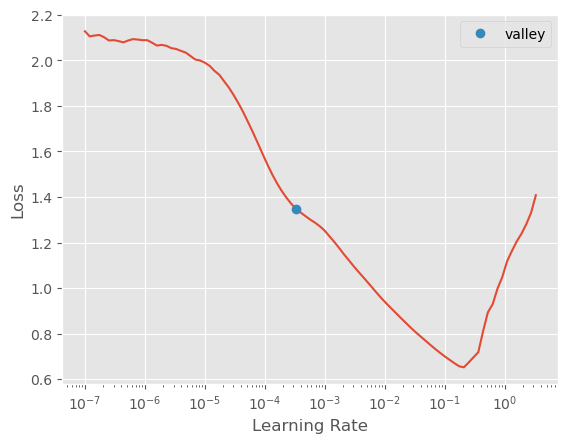

In [38]:
# Using fastai lr_find method to find the optimal learning_rate value to use
learn.lr_find()

In [39]:
# Fitting the tabular_learner 
learn.fit_one_cycle(n_epoch=25, lr_max=0.015)

epoch,train_loss,valid_loss,time
0,0.033430,0.017886,00:01
1,0.020366,0.033013,00:02
2,0.018877,0.026955,00:01
3,0.019560,0.015769,00:01
4,0.016841,0.022417,00:01
5,0.018716,0.021174,00:01
6,0.016569,0.016741,00:01
7,0.016426,0.016638,00:01
8,0.014834,0.020405,00:01
9,0.016475,0.015605,00:01


In [40]:
# Loss on validation data set
# preds_nn, targs = learn.get_preds()
# mean_squared_error(preds_nn, targs, squared=False)

In [41]:
# Applying same transformations of train data  to the test data
test_dl = learn.dls.test_dl(df_test_nn.drop("id", axis=1))
# Getting predictions
preds,_ = learn.get_preds(dl=test_dl)
# Applying antilog to target variable as it was log transformed
nn_preds = np.exp(preds)

In [42]:
# First 10 predictions
nn_preds[:10]

tensor([[  870.2157],
        [ 2503.0300],
        [ 2344.0566],
        [  859.6071],
        [ 5661.6572],
        [  758.5616],
        [12088.4443],
        [ 3001.2622],
        [15318.8418],
        [ 1849.4086]])

In [43]:
# Function to create a submission file
def create_submission(Id, price, file_name):
    ss["id"] = Id
    ss['price'] = price
    ss.to_csv(f"{file_name}.csv", index=False)

Text(0.5, 0, 'Predictions')

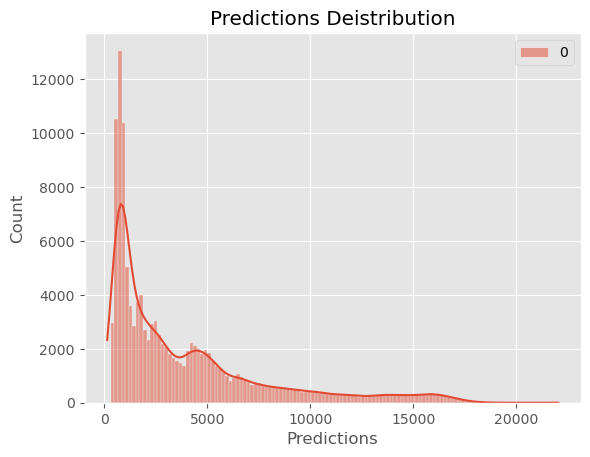

In [44]:
# Plotting the predictions distribution
sns.histplot(nn_preds, kde=True)
plt.title("Predictions Deistribution")
plt.xlabel("Predictions")

# Machine Learning Algorithms

In [45]:
# Creating a separate copy of train and test dataset for training ML models
df_train_ml = df_train.copy()
df_test_ml = df_test.copy()

# Mapping the categorical values
df_train_ml = map_cat_columns(df_train_ml, cat_columns)
df_test_ml = map_cat_columns(df_test_ml, cat_columns)

# Feature Engineering
df_train_ml = feature_engineer(df_train_ml)
df_test_ml = feature_engineer(df_test_ml)

In [46]:
# Splitting features and target variable
features = df_train_ml.drop(columns=["price", "id"])
target = df_train_ml['price']

In [47]:
# Features dataframe
features.head()

,carat,cut,color,clarity,depth,table,x,y,z,square_xyz
0,1.52,4,4,5,62.2,58.0,7.27,7.33,4.55,127.2843
1,2.03,3,0,3,62.0,58.0,8.06,8.12,5.05,156.4005
2,0.70,1,3,6,61.2,57.0,5.69,5.73,3.50,77.4590
3,0.32,1,3,6,61.6,56.0,4.38,4.41,2.71,45.9766
4,1.70,4,3,5,62.6,59.0,7.65,7.61,4.77,139.1875


In [48]:
# Function for training Lightbgm and Catboost models
def train_ml(model, params, features, target, val=True):
    
    if val:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

        m = model(**params)
        if model == LGBMRegressor:
            m.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 eval_metric="rmse",
                 early_stopping_rounds=100,
                 verbose=0)
            return m
        
        if model == CatBoostRegressor:
            m.fit(X_train, y_train,
                    eval_set=[(X_test, y_test)],
                    verbose=0,) 
            return m 
        
    else:
        m = model(**params)
        m.fit(features, target,
              verbose=0)
        return m

# Fucntion to get predictions from the model
def predict(model, test):
    preds = model.predict(test)
    return preds

In [49]:
# Function for cross validation
def cross_validate(X, y, model, params):
    # we'll use 5 fold cross validation
    N_FOLDS = 5
    cv_scores = np.zeros(N_FOLDS)
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    m = model(**params)
    
    for fold_id, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if model == LGBMRegressor:
            m.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     eval_metric="rmse",
                     early_stopping_rounds=50,
                     verbose=-1)

        if model == CatBoostRegressor:
            m.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     verbose=0)

        y_preds = m.predict(X_val)        
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_id] = rmse
        print(f"-->> Training Fold: {fold_id}")
        print(f"     rmse: {rmse}")
            
    
    avg_rmse = np.mean(cv_scores)
    print(f"Avg RMSE across folds: {avg_rmse}")

In [50]:
# Function to create a dataframe with features and their feature importances
def df_feat_importance(model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [51]:
# Function to plot the feature importances of the models
def plot_fi(fi):
    # return fi.plot('cols', 'imp', 'bar', figsize=(12,7), legend=False)
    return sns.barplot(data=fi, x = 'imp' , y = 'cols', orient='horizontal')

## Lightgbm

In [52]:
# LGBMRegressor parameters
lgbm_params_1 = {"learning_rate":0.015,
            "objective":"regression",
            "n_estimators":4000,
            "num_leaves":40,
            "max_depth":5,
            "min_child_samples":15,
            "n_jobs":6,
            "random_state":42}

lgbm_params_2 = {"n_estimators":10000,
          "learning_rate":0.015,
          "max_depth":5,
          "num_leaves":40,
          "n_jobs":6,
          "random_state":42}

In [53]:
# Cross validation
cross_validate(features, target, LGBMRegressor, lgbm_params_1)

-->> Training Fold: 0
     rmse: 565.3205973337042
-->> Training Fold: 1
     rmse: 578.730269432276
-->> Training Fold: 2
     rmse: 575.3805253554362
-->> Training Fold: 3
     rmse: 576.033870190139
-->> Training Fold: 4
     rmse: 562.5077178622926
Avg RMSE across folds: 571.5945960347696


In [54]:
# Training the model using data from train_test_split
model = train_ml(LGBMRegressor, lgbm_params_1, features, target, val=True)

print(f"rmse : {model.best_score_['valid_0']['rmse']} \nl2: {model.best_score_['valid_0']['l2']}")

rmse : 567.7077699197547 
l2: 322292.1120272611


In [55]:
# Training on the whole dataset
lgbm_full = train_ml(LGBMRegressor, lgbm_params_1, features, target, val=False)
lgbm_preds = predict(lgbm_full, df_test_ml[features.columns])

# First 10 predictions
lgbm_preds[:10]

array([  856.79359233,  2520.43533852,  2360.96410467,   862.80329129,
        5785.03807319,   729.22355545, 12542.41359992,  3011.69622809,
       15351.214709  ,  1903.75579013])

<AxesSubplot:xlabel='imp', ylabel='cols'>

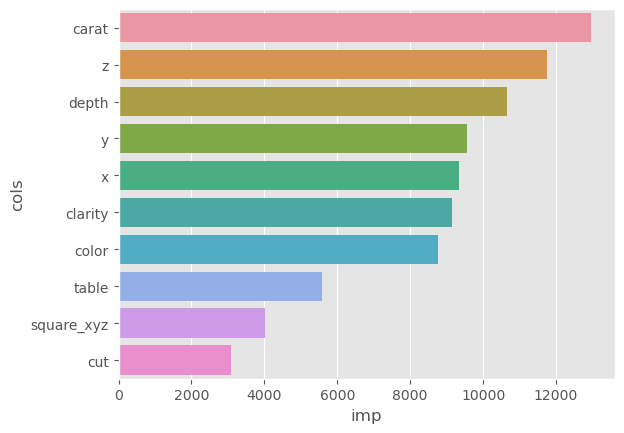

In [56]:
# Feature Importance
fi = df_feat_importance(lgbm_full, features)

# Feature Importance plot
plot_fi(fi)

Text(0.5, 0, 'Predictions')

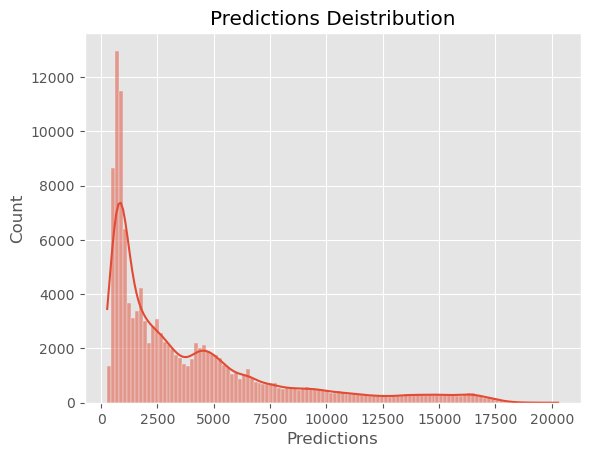

In [57]:
# Plotting the predictions distribution
sns.histplot(lgbm_preds, kde=True)
plt.title("Predictions Deistribution")
plt.xlabel("Predictions")

## Catboost

In [58]:
# CatBoostRegressor parameters
cbr_params = {'iterations':4000,
 'learning_rate':0.01,
 'eval_metric':'RMSE',
 'early_stopping_rounds':300}

In [59]:
# Cross validation
cross_validate(features, target, CatBoostRegressor, cbr_params)

-->> Training Fold: 0
     rmse: 562.8492868711701
-->> Training Fold: 1
     rmse: 576.1174327219408
-->> Training Fold: 2
     rmse: 572.3798248978042
-->> Training Fold: 3
     rmse: 576.4569750704101
-->> Training Fold: 4
     rmse: 560.5695816813368
Avg RMSE across folds: 569.6746202485324


In [60]:
# Training the model using train_test_split
cbr = train_ml(CatBoostRegressor, cbr_params, features, target, val=True)
print(cbr.best_score_)

{'learn': {'RMSE': 549.2296822320626}, 'validation': {'RMSE': 569.2796051920409}}


In [61]:
# Training the model on whole dataset
cbr_full = train_ml(CatBoostRegressor, cbr_params, features, target, val=False)
cbr_preds = predict(cbr_full, df_test_ml[features.columns])

# First 10 predictions
cbr_preds[:10]

array([  878.61586393,  2528.57108119,  2320.19448653,   850.66257531,
        5816.35750969,   711.17016918, 12446.86538342,  2942.41911056,
       15649.57626193,  1861.40798473])

<AxesSubplot:xlabel='imp', ylabel='cols'>

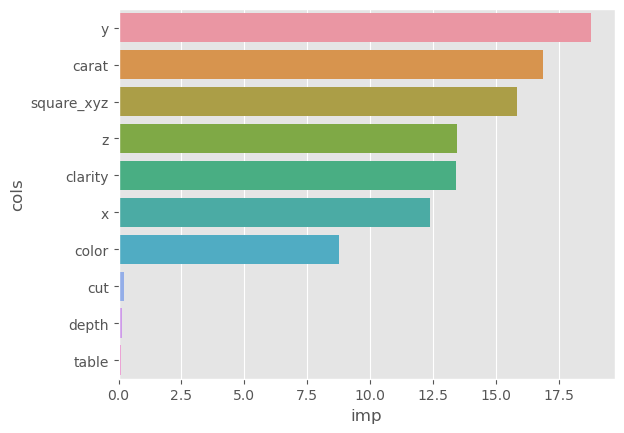

In [62]:
# Feature Importance
fi = df_feat_importance(cbr_full, features)

# Plotting feature importance
plot_fi(fi)

# Ensembling

In [63]:
# Average precitions of Neurral Networks, Lightgbm and CatBoost
ens_preds = np.array([to_np(nn_preds).squeeze(), cbr_preds, lgbm_preds]).mean(axis=0)

# Ensembling NN, LGBM, CatBoost, and RandomForest
# ens_preds = np.array([to_np(nn_preds).squeeze(), cbr_preds, lgbm_preds, rf_preds]).mean(axis=0)

In [64]:
# First 10 predictions after ensembling
ens_preds[:10]

array([  868.54171817,  2517.345483  ,  2341.73841061,   857.69099443,
        5754.35093648,   732.98510304, 12359.24110643,  2985.12584856,
       15439.87758927,  1871.52411473])

# Creating a Submission file

In [65]:
# Creating a submission file
create_submission(df_test_ml["id"], ens_preds, "ens_preds_nn_cbr_lgbm_feat_engineering_1")